In [ ]:
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import talib, math
import keras
import keras.models
import keras.callbacks
import mpl_finance as mpf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Activation, Dense, Dropout, Input, Embedding, Bidirectional, TimeDistributed
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from google.colab import files

In [ ]:
_df = pd.read_csv('Australia_data.csv')
# df = pd.read_csv('Germany_data.csv')
_df.head()

,Date,Open,High,Low,Close,Volume,ma10,ma30,K,D,covid
0,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3757910000,3281.491968,0.0,35.677664,37.742791,3
1,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3995320000,3279.171973,0.0,49.033572,39.681079,1
2,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,4117730000,3280.465967,0.0,76.996968,53.902734,1
3,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3868370000,3282.489966,0.0,95.299348,73.776629,1
4,2020-02-07,3335.540039,3341.419922,3322.120117,3327.709961,3730650000,3285.713965,0.0,92.660245,88.318854,0


In [ ]:
def normalize(df):
  norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
  return norm

In [ ]:
scaler_c = preprocessing.MinMaxScaler()
scaler_c.fit(_df['Close'].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
df = _df.copy()
start = 1
end = 11
df.iloc[:,start:end] = normalize(df.iloc[:,start:end])
df.head()

,Date,Open,High,Low,Close,Volume,ma10,ma30,K,D,covid
0,2020-02-03,0.701085,0.719348,0.726137,0.722024,0.156307,0.723502,0.0,0.346881,0.353227,0.002128
1,2020-02-04,0.734434,0.747952,0.757407,0.756765,0.194195,0.721517,0.0,0.485042,0.373983,0.000709
2,2020-02-05,0.767302,0.770743,0.780461,0.783247,0.213729,0.722624,0.0,0.774310,0.526273,0.000709
3,2020-02-06,0.782148,0.778459,0.794820,0.791163,0.173935,0.724356,0.0,0.963640,0.739088,0.000709
4,2020-02-07,0.775188,0.773598,0.786284,0.778265,0.151957,0.727115,0.0,0.936339,0.894810,0.000000


## 1、 Generate training dataset

In [ ]:
# def splitData(x,y,rate):
#   x_train = x[int(x.shape[0]*rate):]
#   y_train = y[int(y.shape[0]*rate):]
#   x_val = x[:int(x.shape[0]*rate)]
#   y_val = y[:int(y.shape[0]*rate)]
#   return x_train, y_train, x_val, y_val

In [ ]:
# x_train, y_train, x_val, y_val = splitData(x,y,0.2)
# print(x_train.shape,y_train.shape)
# print(x_val.shape,y_val.shape)
# x_train = x_train.astype('float64')
# y_train = y_train.astype('float64')

(164, 5, 10) (164, 1)
(41, 5, 10) (41, 1)


In [ ]:
def gen_input_data(data, time_step = 5, future_day = 1):

    data_date = data["Date"]
    # print(data_date)
    data = data.drop(["Date"], axis = 1)
    date_list = []
    train_x, train_y = [], []
    for i in range(data.shape[0]-time_step):
        # print(data_date[i])
        date_list.append(data_date[i+time_step])
        train_x.append(np.array(data.iloc[i:i+time_step]))
        train_y.append(np.array(data.iloc[i+time_step:i+time_step+future_day]["Close"]))
    return np.array(train_x), np.array(train_y), date_list

In [ ]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [ ]:
def split_data(Date, date_list):
	target_date = 0
	for idx, d in enumerate(date_list):
	    if d > Date:
	        target_date = idx
	        break

	x_val = x[target_date:]
	y_val = y[target_date:]
	x_train = x[:target_date]
	y_train = y[:target_date]
	return x_train, y_train, x_val, y_val

In [ ]:
x, y, date_list = gen_input_data(df ,time_step = 5)

x_train, y_train, x_val, y_val = split_data("2020-09-30", date_list)

x_train, y_train = shuffle(x_train, y_train)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(163, 5, 10) (163, 1)
(42, 5, 10) (42, 1)


## 2、Model

In [ ]:
# def BDLSTM_model(shape):
#   model = Sequential()
#   model.add(Bidirectional(LSTM(units=128,return_sequences=True),input_shape=(shape[1], shape[2])))
#   model.add(Bidirectional(LSTM(units=64)))
#   forward_layer = LSTM(64, return_sequences=False)
#   backward_layer = LSTM(64, activation='relu', return_sequences=False, go_backwards=True)
#   model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
#   # model.add(Dropout(0.2))
#   # model.add(BatchNormalization())
#   # model.add(TimeDistributed(Dense(1, activation='sigmoid')))
  
#   model.add(Dense(1))
#   model.compile(loss='mse', optimizer='adam')
#   model.summary()
#   return model

# def BDLSTM_model(shape):
    
#   model = Sequential()
#   forward_layer = LSTM(32, return_sequences=False)
#   backward_layer = LSTM(32, activation='relu', return_sequences=False, go_backwards=True)
#   model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(shape[1], shape[2])))
#   model.add(Dense(1))
#   # model.add(Activation('softmax'))
#   model.compile(loss='mse', optimizer='adam')
#   model.summary()
#   return model

def BDLSTM_model(shape):
    
    model = Sequential()
    forward_layer = LSTM(128, return_sequences=False)
    backward_layer = LSTM(128, activation='relu', return_sequences=False, go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    # model.add(Activation('softmax'))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [ ]:
model_BDLSTM = BDLSTM_model(x_train.shape)

In [ ]:
def LSTM_DNN_model(shape):

  model = Sequential()
  model.add(LSTM(32, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(Dense(32,kernel_initializer='uniform',activation='relu'))
  model.add(Dense(16,kernel_initializer='uniform',activation='relu'))
  model.add(LSTM(16, return_sequences=False))
  # model.add(LSTM(10, return_sequences=False))
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

# def LSTM_DNN_model(shape):

#   model = Sequential()
#   model.add(LSTM(80, input_length=shape[1], input_dim=shape[2], return_sequences=True))
#   model.add(Dense(40,kernel_initializer='uniform',activation='relu'))
#   model.add(Dense(40,kernel_initializer='uniform',activation='relu'))
#   model.add(LSTM(10, return_sequences=False))
#   model.add(Dense(1))
#   model.compile(loss="mse", optimizer="adam")
#   model.summary()
#   return model

In [ ]:
model_BDLSTM = LSTM_DNN_model(x_train.shape)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 5, 32)             5504      
_________________________________________________________________
dense_43 (Dense)             (None, 5, 32)             1056      
_________________________________________________________________
dense_44 (Dense)             (None, 5, 16)             528       
_________________________________________________________________
lstm_84 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


## 3、Train

In [ ]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# history_BDLSTM = model_BDLSTM.fit(x_train, y_train, epochs = 1000, batch_size = 16, validation_data=(x_val, y_val), callbacks=[callback])
history_BDLSTM = model_BDLSTM.fit(x_train, y_train, epochs = 1000, batch_size = 16, validation_split=0.2, callbacks=[callback])
# history_BDLSTM = model_BDLSTM.fit(x_train, y_train, epochs = 1000, batch_size = 16, validation_split=0.2)

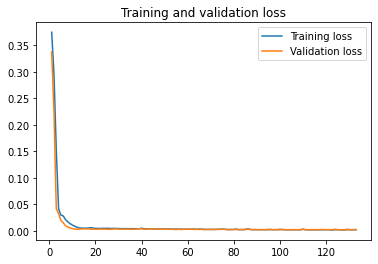

In [ ]:
loss_BDLSTM = history_BDLSTM.history['loss']
val_loss_BDLSTM = history_BDLSTM.history['val_loss']
epochs_BDLSTM = range(1, len(loss_BDLSTM) + 1)

# plt.figure()
plt.plot(epochs_BDLSTM, loss_BDLSTM, label='Training loss')
plt.plot(epochs_BDLSTM, val_loss_BDLSTM, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# # history_LSTM_DNN = model_LSTM_DNN.fit(x_train, y_train, epochs = 1000, batch_size = 64, validation_data=(x_val, y_val), callbacks=[callback])
# history_LSTM_DNN = model_LSTM_DNN.fit(x_train, y_train, epochs = 1000, batch_size = 16, validation_split=0.2, callbacks=[callback])
# # history_LSTM_DNN = model_LSTM_DNN.fit(x_train, y_train, epochs = 100, batch_size = 10, validation_split=0.2)

In [ ]:
# loss_LSTM_DNN = history_LSTM_DNN.history['loss']
# val_loss_LSTM_DNN = history_LSTM_DNN.history['val_loss']
# epochs_LSTM_DNN = range(1, len(loss_LSTM_DNN) + 1)

# # plt.figure()
# plt.plot(epochs_LSTM_DNN, loss_LSTM_DNN, label='Training loss')
# plt.plot(epochs_LSTM_DNN, val_loss_LSTM_DNN, label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

## 4、 Predict

In [ ]:
vy = y_val.reshape((-1,))
vy_origin = scaler_c.inverse_transform(y_val)

In [ ]:
predict_BDLSTM = model_BDLSTM.predict(x_val)

py_BDLSTM_origin = scaler_c.inverse_transform(predict_BDLSTM)

mse_BDLSTM = mean_squared_error(vy, predict_BDLSTM)
print('mse_BDLSTM:',mse_BDLSTM)

mse_BDLSTM_org = mean_squared_error(vy_origin, py_BDLSTM_origin)
print('mse_BDLSTM_org:',mse_BDLSTM_org)

mse_BDLSTM: 0.002886313886268049
mse_BDLSTM_org: 5664.851281009679


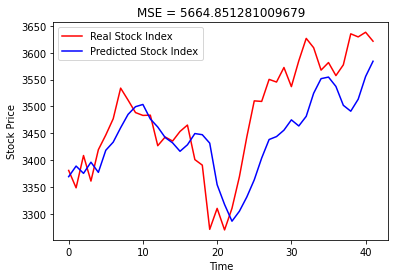

In [ ]:
plt.plot(vy_origin, color = 'red', label = 'Real Stock Index')  # 紅線表示真實股價
plt.plot(py_BDLSTM_origin, color = 'blue', label = 'Predicted Stock Index')  # 藍線表示預測股價
plt.title('MSE = ' + str(mse_BDLSTM_org))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# np.save('BDLSTM',py_BDLSTM_origin)
# files.download('BDLSTM.npy')

# np.save('vy_origin',vy_origin)
# files.download('vy_origin.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 二、LSTM_DNN

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error as mse

In [ ]:
df = pd.read_csv('Australia_data.csv')
# df.drop('Volume',axis=1,inplace=True)
df = df[(df['Date'] >= "2020-02-01") & (df['Date'] <= "2020-11-30")]

In [ ]:
df.head()

In [ ]:
def normalization(df):
    #df.drop('Date',axis=1,inplace=True)
    col = df.columns.drop('Date')
    for x in col:
        mini = min(df[x])
        maxi = max(df[x])
        if x == 'Close':
            close_max = maxi
            close_min = mini
        df[x] = (df[x] - mini)/(maxi - mini)
    return df, close_max, close_min

In [ ]:
df_norm,  close_max, close_min  = normalization(df.copy())
df_norm = df_norm.reset_index(drop=True)

In [ ]:
def gen_input_data(data, time_step = 5, future_day = 1):

    data_date = data["Date"]
    # print(data_date)
    data = data.drop(["Date"], axis = 1)
    date_list = []
    train_x, train_y = [], []
    for i in range(data.shape[0]-time_step):
        # print(data_date[i])
        date_list.append(data_date[i+time_step])
        train_x.append(np.array(data.iloc[i:i+time_step]))
        train_y.append(np.array(data.iloc[i+time_step:i+time_step+future_day]["Close"]))
    return np.array(train_x), np.array(train_y), date_list

In [ ]:
time_step = 5
train_x, train_y, date_list = gen_input_data(df_norm,time_step)
print(train_x.shape, train_y.shape, len(date_list))

(205, 5, 10) (205, 1) 205


In [ ]:
target_date = 0
for idx, d in enumerate(date_list):
    if d > "2020-09-30":
        print(idx, d)
        target_date = idx
        break
print(target_date)

163 2020-10-01
163


In [ ]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [ ]:
valid_x = train_x[target_date:]
valid_y = train_y[target_date:]
train_x = train_x[:target_date]
train_y = train_y[:target_date]
train_x, train_y = shuffle(train_x, train_y)

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

(163, 5, 10) (163, 1)
(42, 5, 10) (42, 1)


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X_valid = torch.tensor(valid_x,dtype=torch.float32).to(device)
X_train = torch.tensor(train_x,dtype=torch.float32).to(device)
y_valid = torch.tensor(valid_y,dtype=torch.float32).to(device)
y_train = torch.tensor(train_y,dtype=torch.float32).to(device)

In [ ]:
class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, n_layers=1, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm0 = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)  
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device).requires_grad_()
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device).requires_grad_()
        r_out0, (hidden_state, c) = self.lstm0(x,(h0.detach(),c0.detach()))
        h1 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device).requires_grad_()
        c1 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device).requires_grad_()
        r_out1, (hidden_state1, c1) = self.lstm1(r_out0,(h1.detach(),c1.detach()))
        h2 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device).requires_grad_()
        c2 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device).requires_grad_()
        r_out2, (hidden_state2, c2) = self.lstm2(r_out1,(h2.detach(),c2.detach()))
        outs = []
        for time in range(r_out1.size(1)):
            o = self.fc(r_out2[:, time, :].reshape(-1,self.hidden_size))
            outs.append(o[:].reshape(r_out2.shape[0],-1))
        return torch.stack(outs, dim=1)

In [ ]:
input_size = 10
hidden_size = 128
n_layers = 1
output_size = 1
lstm = LSTM(input_size, hidden_size, n_layers, output_size)

In [ ]:
epoch = 100
loss_f = nn.MSELoss()
lr = 0.01
optimizer = optim.Adam(lstm.parameters(), lr=lr)
lstm.to(device)
lstm_train_loss, lstm_valid_loss = [], []

for i in range(1,epoch+1):
    print("epoch: {}/{}".format(i,epoch), end = '')
    optimizer.zero_grad()
    lstm_output = lstm(X_train)
    lstm_loss = loss_f(lstm_output[:,time_step-1,0].reshape(-1,1),y_train)
    lstm_train_loss.append(lstm_loss.item())
    print(", train loss: {: 4f}".format(lstm_loss.item()), end='')
    lstm_loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        lstm_output2 = lstm(X_valid)
        lstm_v_loss = loss_f(lstm_output2[:,time_step-1,0].reshape(-1,1), y_valid)
        print(", validation loss: {:4f}.".format(lstm_v_loss.item()))
        lstm_valid_loss.append(lstm_v_loss.item())

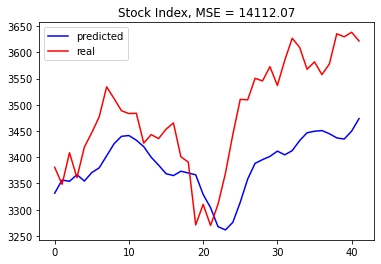

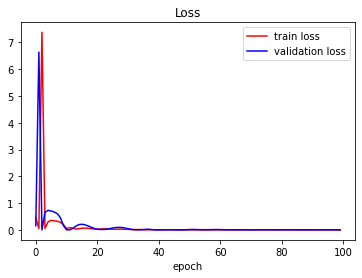

In [ ]:
predict = lstm_output2[:,time_step-1,0].detach().cpu().numpy().reshape(-1,1)
predict = predict * (close_max - close_min) + close_min
real_index = np.array(df.loc[target_date + time_step:, 'Close']).reshape(-1,1)

mserr = mse(predict, real_index)

plt.plot(predict,color='b',label='predicted')
plt.plot(real_index,color='r',label='real')
plt.legend()
plt.title(f'Stock Index, MSE = {round(mserr,2)}')
# plt.savefig('Australia_DNN_LSTM.png')
plt.show()
fig = plt.figure()
plt.plot(lstm_train_loss,color='r',label='train loss')
plt.plot(lstm_valid_loss,color='b',label='validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
# plt.savefig('Australia_DNN_lstm_loss.png')
plt.show()

## PLOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Three_line_plot

In [ ]:
real = np.load('Australia.npy')
BDLSTM = np.load('Australia_BDLSTM.npy')
DNN = np.load('Australia_DNN.npy')

In [ ]:
mse_BDLSTM = mean_squared_error(real, BDLSTM)
print(mse_BDLSTM)

4924.236594009022


In [ ]:
mse_DNN = mean_squared_error(real, DNN)
print(mse_DNN)

37638.91296936321


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

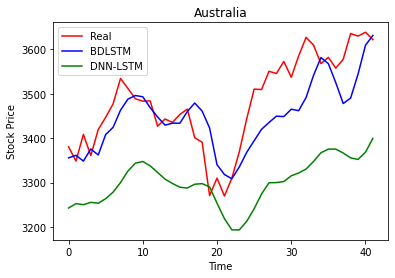

In [ ]:
plt.plot(real, color = 'red', label = 'Real')  # 紅線表示真實股價
plt.plot(BDLSTM, color = 'blue', label = 'BDLSTM')  # 藍線表示預測股價
plt.plot(DNN, color = 'green', label = 'DNN-LSTM')  # 藍線表示預測股價
plt.title('Australia')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Australia.png')
files.download('Australia.png')
plt.show()

In [ ]:
real = np.load('Germany.npy')
BDLSTM = np.load('Germany_BDLSTM.npy')
DNN = np.load('Germany_DNN.npy')

In [ ]:
mse_BDLSTM = mean_squared_error(real, BDLSTM)
print(mse_BDLSTM)

300909.88227594265


In [ ]:
mse_DNN = mean_squared_error(real, DNN)
print(mse_DNN)

596048.4935428086


In [ ]:
plt.plot(real, color = 'red', label = 'Real')  # 紅線表示真實股價
plt.plot(BDLSTM, color = 'blue', label = 'BDLSTM')  # 藍線表示預測股價
plt.plot(DNN, color = 'green', label = 'DNN-LSTM')  # 藍線表示預測股價
plt.title('Germany')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Germany.png')
files.download('Germany.png')
plt.show()

Month10-11_plot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
covid_pd = pd.read_csv('Australia_covid.csv')

In [ ]:
def covid_preprocess(covid_pd):

    covid_pd = covid_pd.rename(columns = {'date': 'Date'}, inplace = False)

    features = list(covid_pd.columns)
    print(features)
    features = features[:2]
    covid_pd = covid_pd[features]

    covid_pd = covid_pd.dropna()

    for i in range(len(covid_pd['Date'])):
        temp = covid_pd.loc[i,'Date']
        if '/' in temp:
            # print(covid_pd.loc[i,'Date'])
            
            temp = time.strptime(temp, "%Y/%m/%d")
            nt = time.strftime("%Y-%m-%d", temp)
            # print(nt)
            covid_pd.loc[i,'Date'] = nt

    return covid_pd

In [ ]:
covid_pd = covid_preprocess(covid_pd)
covid_pd = covid_pd[(covid_pd['Date'] >= "2020-10-01") & (covid_pd['Date'] <= "2020-11-30")]
covid_pd = covid_pd.reset_index(drop=True)
covid_case = covid_pd['confirmed_cases']

['Date', 'confirmed_cases']


No handles with labels found to put in legend.


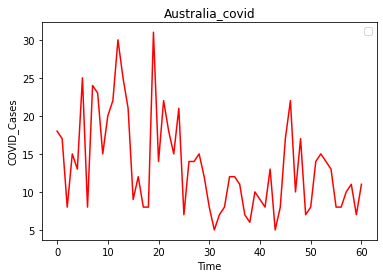

In [ ]:
plt.plot(covid_case, color = 'red')  

plt.title('Australia_covid')
plt.xlabel('Time')
plt.ylabel('COVID_Cases')
plt.legend()
plt.show()

## Data produce

In [ ]:
import numpy as np
import pandas as pd
import talib
import time
import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--country', type=str, default='UK', help='Data of country')
# opts = parser.parse_args()

# stock_path = opts.country + '_stock.csv'
# covid_path = opts.country + '_covid.csv'
stock_path = 'Germany_stock.csv'
covid_path = 'Germany_covid.csv'
stock = pd.read_csv(stock_path)
covid = pd.read_csv(covid_path)
stock.drop('Adj Close', axis=1, inplace=True)
ma10 = talib.SMA(np.array(stock['Close']),10)
ma30 = talib.SMA(np.array(stock['Close']),30)
stock['ma10'], stock['ma30'] = ma10, ma30
stock['K'], stock['D'] = talib.STOCH(stock['High'],stock['Low'],stock['Close'])
stock.fillna(value=0,inplace=True)

def covid_preprocess(covid_pd):

    covid_pd = covid_pd.rename(columns = {'date': 'Date'}, inplace = False)

    features = list(covid_pd.columns)
    # print('features',features)

    features = features[:2]
    covid_pd = covid_pd[features]

    covid_pd = covid_pd.dropna()

    for i in range(len(covid_pd['Date'])):
        # print(covid_pd.loc[i,'Date'])
        temp = covid_pd.loc[i,'Date']
        temp = time.strptime(temp, "%Y/%m/%d")
        nt = time.strftime("%Y-%m-%d", temp)
        # print(nt)
        covid_pd.loc[i,'Date'] = nt

    return covid_pd

covid = covid_preprocess(covid)

def stock_preprocess(stock_pd):

    stock_pd['Date'] = pd.to_datetime(stock_pd['Date'])
    
    for i in range(len(stock_pd['Date'])):
        temp = stock_pd.loc[i,'Date']
        temp = str(temp).split(' ')[0]
        stock_pd.loc[i,'Date'] = temp

    #     '''
    #     str_i = "20081231"
    #     list_i = list(i)
    #     print(list_i)

    #     list_i.insert(4, '/')
    #     list_i.insert(7, '/')
    #     print(list_i)

    #     str_i = ''.join(i)
    #     '''
    #stock_pd.drop(columns=["Adj Close"],inplace=True)

    return stock_pd

stock = stock_preprocess(stock)

stock = stock[(stock['Date'] >= "2020-02-01") & (stock['Date'] <= "2020-11-30")]
covid = covid[(covid['Date'] >= "2020-02-01") & (covid['Date'] <= "2020-11-30")]

stock = stock.reset_index(drop=True)
covid = covid.reset_index(drop=True)

def merge_pd(stock_pd, covid_pd):

    case = 0
    case_list = []
    for idx_c, date_c in enumerate(list(covid_pd['Date'])):
        case = case + int(covid_pd.loc[idx_c, "confirmed_cases"])
        if date_c in list(stock_pd['Date']):
            # print(idx_c, date_c)
            case_list.append(case)
            case = 0
        else:
            # case = case + covid_pd.loc[idx_c, "confirmed_cases"]
            pass
    stock_pd["covid"]=case_list
    return stock_pd


df = merge_pd(stock, covid)
file_name = 'Germany_data.csv'
df.to_csv(file_name,index=False)
files.download('Germany_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>